In [83]:
#AutoArima forecasting for Crude Oil spot prices in Python 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels
from pmdarima.arima import auto_arima
from datetime import datetime
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

In [84]:
# Loading in the dataframe 
df = pd.read_excel("RWTCD.xls", sheet_name = "Data 1")

# Removing the first 2 rows of records as they are not needed
df = df[2:len(df)]

# Renaming the column names of the dataframe 
df.rename(columns = {'Back to Contents':'Date', 'Data 1: Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'Price'}, inplace = True)

# Setting the dates to be the indexes 
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# Now that our date is the index for each record, we can drop the date column from the dataframe.
df.pop("Date")



1986-01-02    1986-01-02 00:00:00
1986-01-03    1986-01-03 00:00:00
1986-01-06    1986-01-06 00:00:00
1986-01-07    1986-01-07 00:00:00
1986-01-08    1986-01-08 00:00:00
                     ...         
2022-05-10    2022-05-10 00:00:00
2022-05-11    2022-05-11 00:00:00
2022-05-12    2022-05-12 00:00:00
2022-05-13    2022-05-13 00:00:00
2022-05-16    2022-05-16 00:00:00
Name: Date, Length: 9165, dtype: object

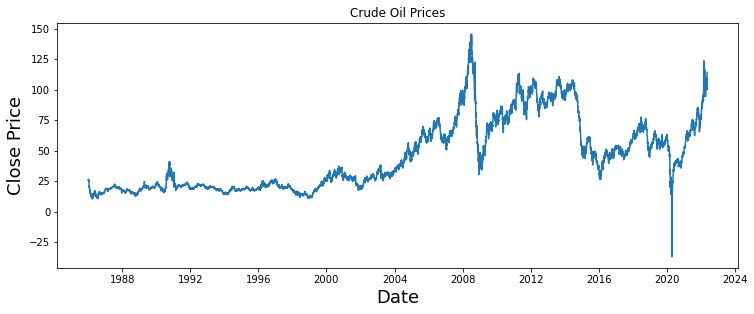

In [85]:
# Checking the datatype of each column in the dataframe 

plt.figure(figsize=(12.2,4.5))
plt.title('Crude Oil Prices')
plt.plot(df['Price'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.show()

# From this graph, we will notice that there are some interesting peaks and troughs in the dataframe.
# For example, there is a peak in the spot prices somewhere around 2008, which followed by a huge crash - this is likely due to the Global Financial Crisis in 2008.as_integer_ratio
# There is also a huge drop in spot prices in 2020, which we all know is likely due to the effects of Covid-19 - if anything, the spot prices actually became negative.
# print(df[df.Price == df.Price.min()]) # - by running this code, we will observe that the minimum price observed is -36.98. 

# Hence, in order to avoid any problems in the log transformation of the data
# We can add a constant to all the prices in the dataframe to perform log transformation.

# k = 50 # constant to be added to all rows in price in order for price to be non-negative

# df["Price"] = df["Price"] + k

# print(df[df.Price == df.Price.min()]) # new lowest price is 13 dollars.


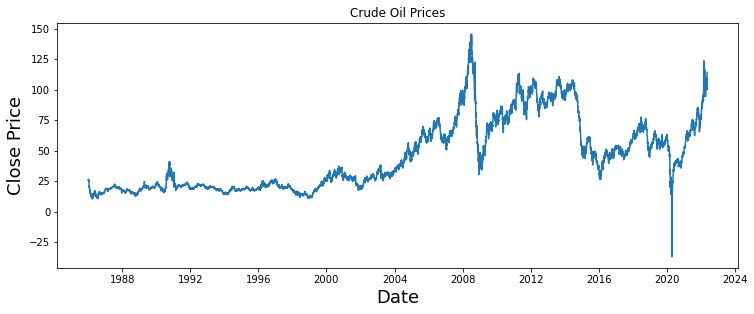

The number of null records in the dataframe is 0.


In [86]:
plt.figure(figsize=(12.2,4.5))
plt.title('Crude Oil Prices')
plt.plot(df['Price'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price', fontsize = 18)
plt.show()

# Checking for null values
nulls = df["Price"].isna().sum()
print(f"The number of null records in the dataframe is {nulls}.")

From the graph above, we can observe that there are large peaks and troughs in the pil prices in the past 30+ years. 

2 main observations can be observed in this dataframe.
1st observation - steady increase in oil prices from 2002 - 2008, with a high price in 2008 before undergoing a major drop. 
2nd observation - sharp decrease in thhe beginning of 2020, before a strong rebound.

We will also observe that our data is non-stationary.
To make it stationary, we will perform log-transformation.

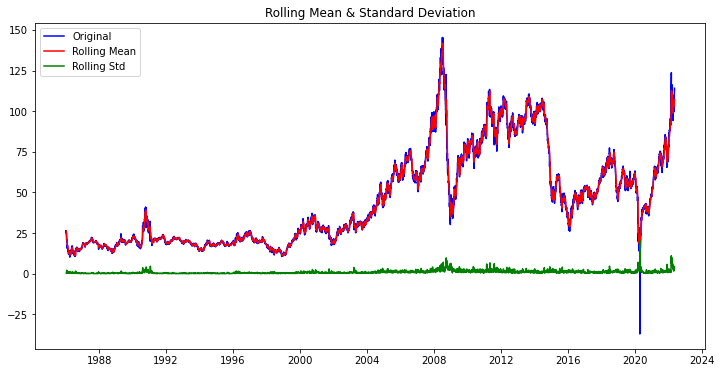


Results of Dickey-Fuller Test: 

Test Statistic                   -1.699233
p-value                           0.431508
#Lags Used                       33.000000
Number of Observations Used    9131.000000
Critical Value (1%)              -3.431066
Critical Value (5%)              -2.861857
Critical Value (10%)             -2.566939
dtype: float64


In [87]:
# Check for stationarity
def stationarity_check(ts):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()

    # Perform the Dickey Fuller test
    dftest = statsmodels.tsa.stattools.adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

stationarity_check(df)



Because the p-value is 0.431508, which is greater than 0.05, we reject the null hypothesis and conclude that the time-series data is not stationary. 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

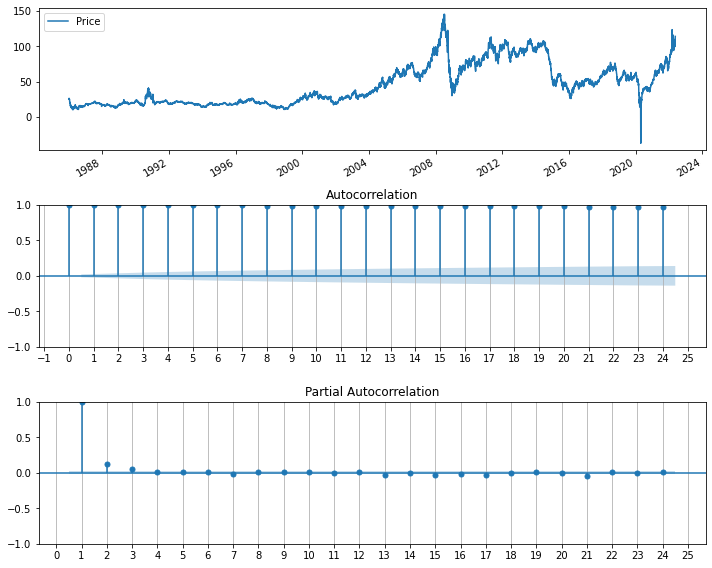

In [88]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    # Plot ts
    ts.plot(ax=ax[0])
    
    # Plot acf, pavf
    plot_acf(ts, ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags, zero=False) # zero=False here because correlation between prices from the same day will always be 1 
    fig.tight_layout()
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

plot_acf_pacf(df)

This PACF plot actually tells us that there is some correlation with the prices when the months prior considered (herein referred to as k) where k = {1,2,3} - based on observation. In layman terms, this means that prices of crude oil from t-1, t-2 and t-3 (where t is the current day considered) have an effect on t. 

A more detailed explanation on ACF and PACF can be found here : https://www.youtube.com/watch?v=DeORzP0go5I

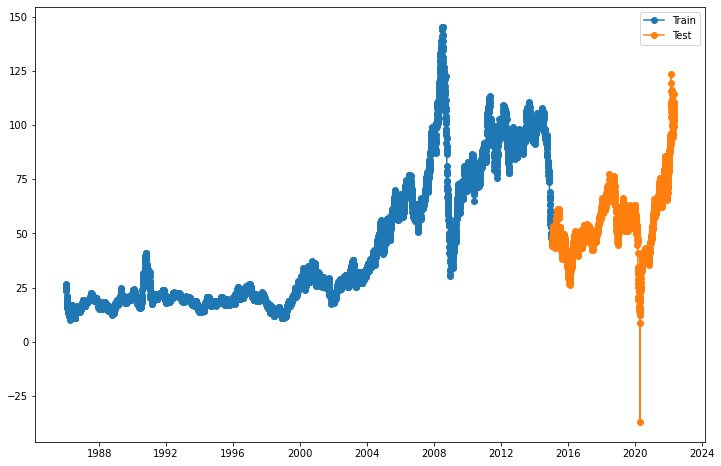

In [89]:
# Splitting the dataframe into testset and trainset 

# Train Test Split Index
train_size = 0.8
split_idx = round(len(df)* train_size)
split_idx

# Split
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [99]:
# Now, we have our train and test data as shown by the graph above. 
# We will need to train our ARIMA model on the train data, and then forecast it using the model, before comparing it to the actual data. 

# Training the arima model using pmd.auto_arima. 
# This will return the ideal p,d,q and fit the model according to the train data. 

model = auto_arima(train)
model.summary()

# Looking at the model summary, we observe that the error term (AIC) is extremely high for this dataset. 
# We can make predictions from this, but we should also take the predictions from this model with a grain of salt. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7332
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -11359.927
Date:                Sat, 28 May 2022   AIC                          22733.854
Time:                        19:57:23   BIC                          22782.153
Sample:                             0   HQIC                         22750.459
                               - 7332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4870      0.065    -22.735      0.000      -1.615      -1.359
ar.L2         -1.2519      0.070    -17.950      0.000      -1.389      -1.115
ar.L3         -0.5102      0.058     -8.728      0.000      -0.625      -0.396
ma.L1          1.4465      0.066     21.754      0.000       1.316       1.577
ma.L2          1.1669      0.072     16.306      0.000       1.027       1.307
ma.L3          0.4429      0.059      7.447      0.000       0.326       0.559
sigma2         1.2986      0.007    191.081      0.000       1.285       1.312
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            138355.58
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               9.50   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""